# Calories Burnt Prediction Challenge

In [1]:
# IMPORTS AND SETUP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# Advanced ML Libraries
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# Statistical Libraries
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting configuration
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
#load data
test_df = pd.read_csv("/kaggle/input/playground-series-s5e5/test.csv")
train_df =pd.read_csv("/kaggle/input/playground-series-s5e5/train.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e5/sample_submission.csv")

In [3]:
# Display basic information about the datasets
if train_df is not None:
    print("\n" + "="*50)
    print("TRAINING DATA OVERVIEW")
    print("="*50)
    print(train_df.info())
    print("\nFirst 5 rows:")
    print(train_df.head())
    
    print("\n" + "="*50)
    print("TEST DATA OVERVIEW")
    print("="*50)
    print(test_df.info())
    print("\nFirst 5 rows:")
    print(test_df.head())


TRAINING DATA OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB
None

First 5 rows:
   id     Sex  Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories
0   0    male   36   189.0    82.0      26.0       101.0       41.0     150.0
1   1  female   64   163.0    60.0       8.0        85.0       39.7      34.0
2   2  female   51   161.0    64.0       7.0        84.0       39.8      29.0
3   3    

# EXPLORATORY DATA ANALYSIS (EDA)


EXPLORATORY DATA ANALYSIS

DESCRIPTIVE STATISTICS - TRAINING DATA:
                  id            Age         Height         Weight  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      41.420404     174.697685      75.145668   
std    216506.495284      15.175049      12.824496      13.982704   
min         0.000000      20.000000     126.000000      36.000000   
25%    187499.750000      28.000000     164.000000      63.000000   
50%    374999.500000      40.000000     174.000000      74.000000   
75%    562499.250000      52.000000     185.000000      87.000000   
max    749999.000000      79.000000     222.000000     132.000000   

            Duration     Heart_Rate      Body_Temp       Calories  
count  750000.000000  750000.000000  750000.000000  750000.000000  
mean       15.421015      95.483995      40.036253      88.282781  
std         8.354095       9.449845       0.779875      62.395349  
min         1.000000      67.000000   

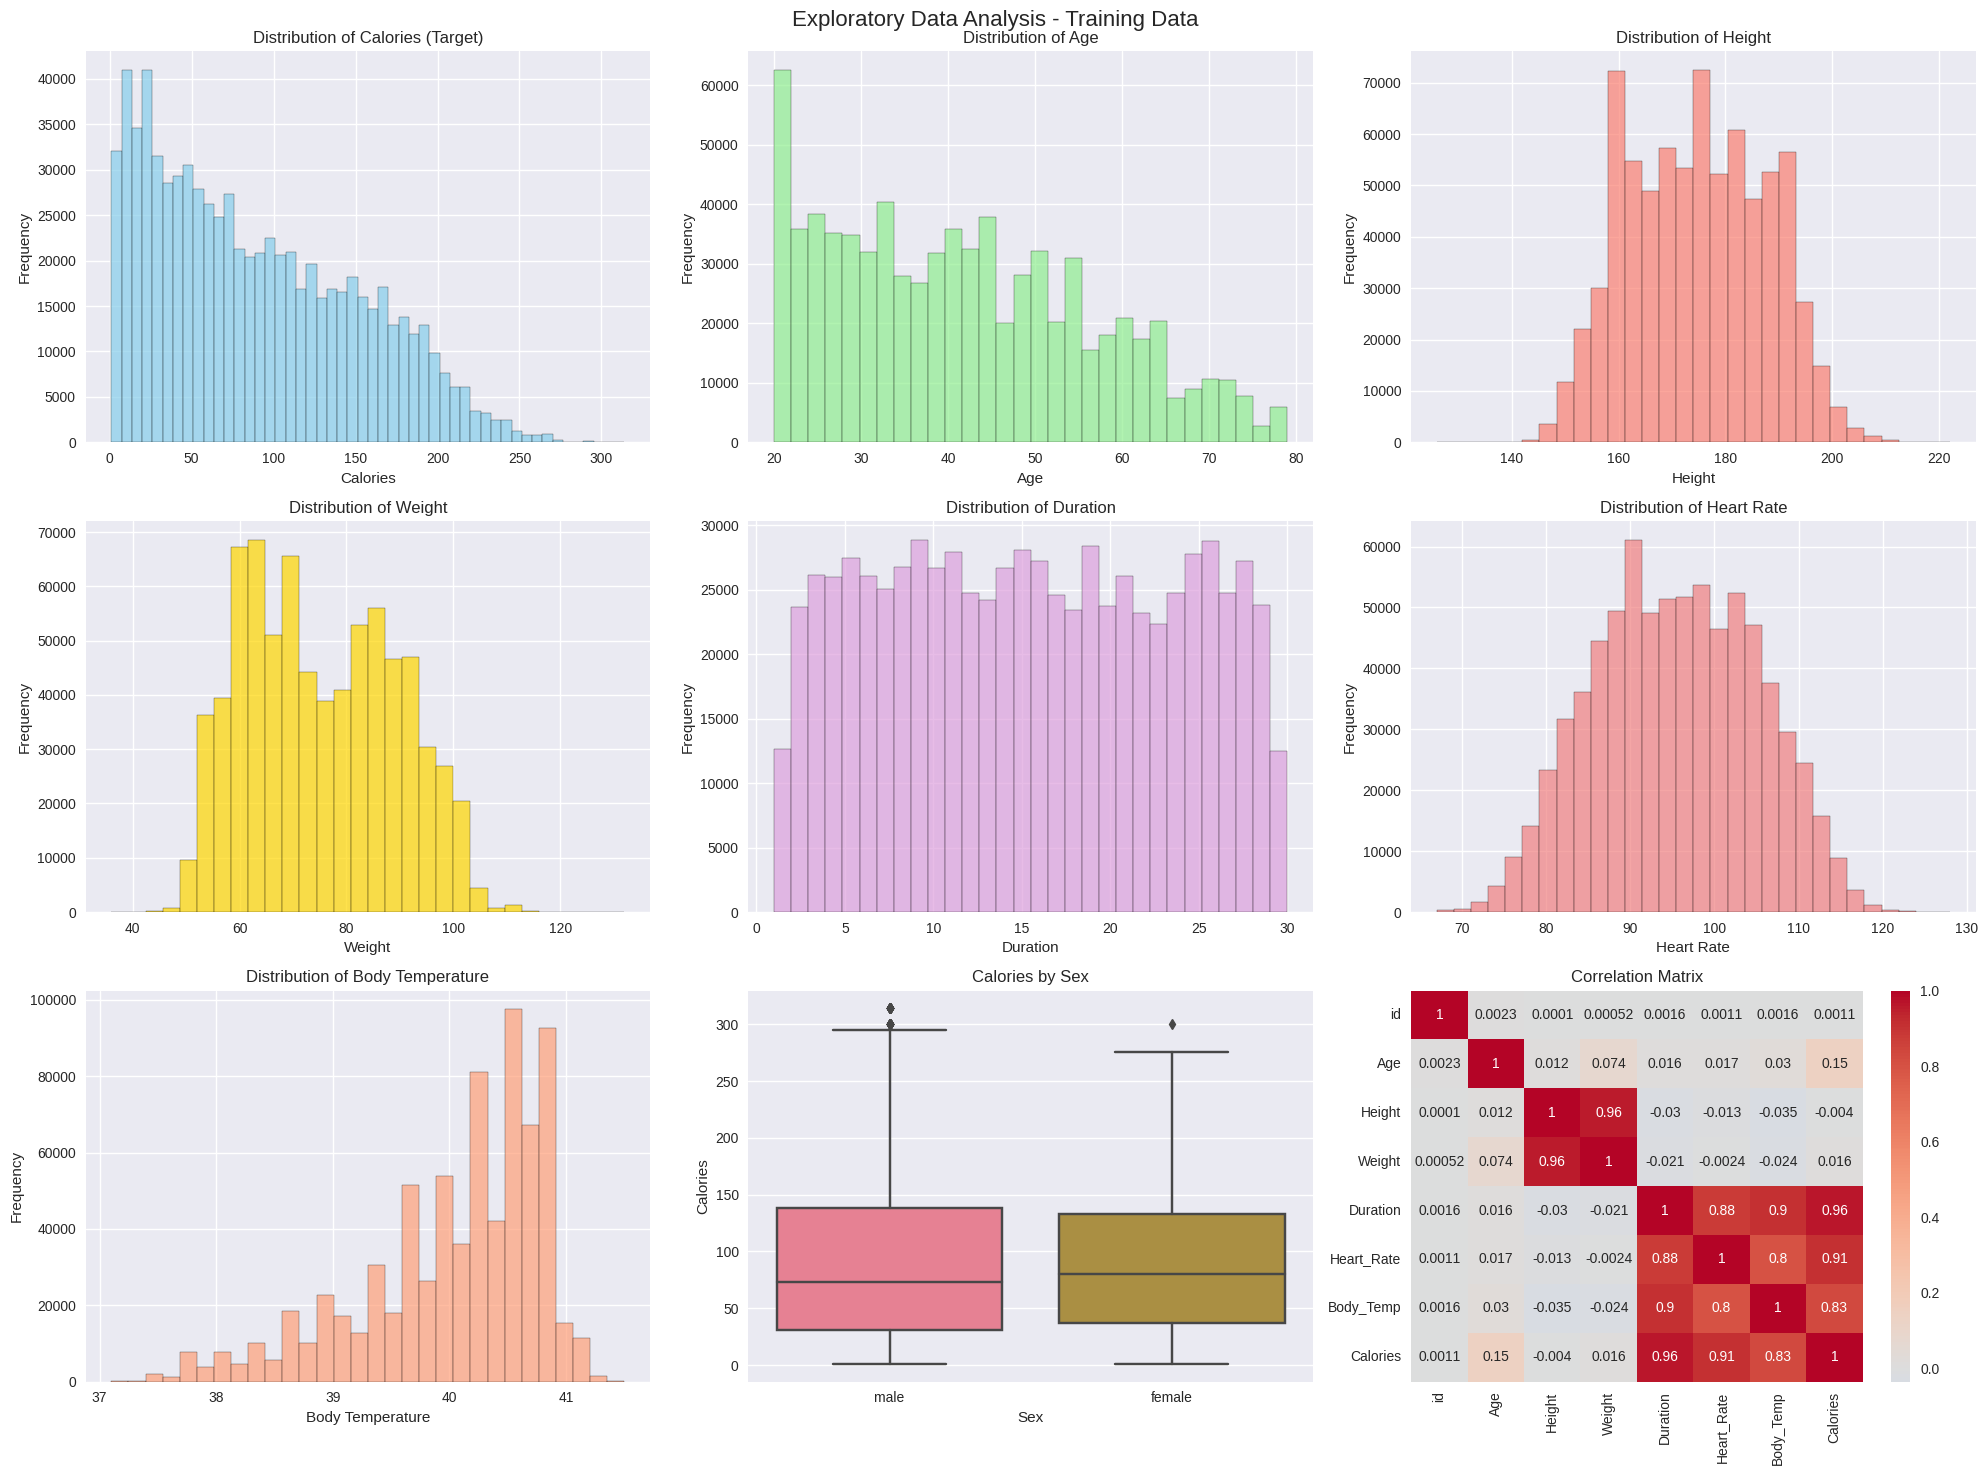


CORRELATION WITH TARGET (Calories):
Duration: 0.9599
Heart_Rate: 0.9087
Body_Temp: 0.8287
Age: 0.1457
Weight: 0.0159
id: 0.0011
Height: -0.0040


In [4]:
def perform_eda(train_df, test_df):
    """Comprehensive Exploratory Data Analysis"""
    
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # Basic statistics
    print("\nDESCRIPTIVE STATISTICS - TRAINING DATA:")
    print(train_df.describe())
    
    # Check for missing values
    print("\nMISSING VALUES:")
    print("Training data missing values:")
    print(train_df.isnull().sum())
    print("\nTest data missing values:")
    print(test_df.isnull().sum())
    
    # Target variable analysis
    print(f"\nTARGET VARIABLE (Calories) ANALYSIS:")
    print(f"Mean: {train_df['Calories'].mean():.2f}")
    print(f"Median: {train_df['Calories'].median():.2f}")
    print(f"Std: {train_df['Calories'].std():.2f}")
    print(f"Min: {train_df['Calories'].min():.2f}")
    print(f"Max: {train_df['Calories'].max():.2f}")
    print(f"Skewness: {train_df['Calories'].skew():.2f}")
    print(f"Kurtosis: {train_df['Calories'].kurtosis():.2f}")
    
    # Sex distribution
    print(f"\nSEX DISTRIBUTION:")
    print("Training data:")
    print(train_df['Sex'].value_counts())
    print("\nTest data:")
    print(test_df['Sex'].value_counts())
    
    # Create visualizations
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Exploratory Data Analysis - Training Data', fontsize=16, y=0.98)
    
    # Target distribution
    axes[0, 0].hist(train_df['Calories'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Calories (Target)')
    axes[0, 0].set_xlabel('Calories')
    axes[0, 0].set_ylabel('Frequency')
    
    # Age distribution
    axes[0, 1].hist(train_df['Age'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[0, 1].set_title('Distribution of Age')
    axes[0, 1].set_xlabel('Age')
    axes[0, 1].set_ylabel('Frequency')
    
    # Height distribution
    axes[0, 2].hist(train_df['Height'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
    axes[0, 2].set_title('Distribution of Height')
    axes[0, 2].set_xlabel('Height')
    axes[0, 2].set_ylabel('Frequency')
    
    # Weight distribution
    axes[1, 0].hist(train_df['Weight'], bins=30, alpha=0.7, color='gold', edgecolor='black')
    axes[1, 0].set_title('Distribution of Weight')
    axes[1, 0].set_xlabel('Weight')
    axes[1, 0].set_ylabel('Frequency')
    
    # Duration distribution
    axes[1, 1].hist(train_df['Duration'], bins=30, alpha=0.7, color='plum', edgecolor='black')
    axes[1, 1].set_title('Distribution of Duration')
    axes[1, 1].set_xlabel('Duration')
    axes[1, 1].set_ylabel('Frequency')
    
    # Heart Rate distribution
    axes[1, 2].hist(train_df['Heart_Rate'], bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 2].set_title('Distribution of Heart Rate')
    axes[1, 2].set_xlabel('Heart Rate')
    axes[1, 2].set_ylabel('Frequency')
    
    # Body Temperature distribution
    axes[2, 0].hist(train_df['Body_Temp'], bins=30, alpha=0.7, color='lightsalmon', edgecolor='black')
    axes[2, 0].set_title('Distribution of Body Temperature')
    axes[2, 0].set_xlabel('Body Temperature')
    axes[2, 0].set_ylabel('Frequency')
    
    # Sex vs Calories boxplot
    sns.boxplot(data=train_df, x='Sex', y='Calories', ax=axes[2, 1])
    axes[2, 1].set_title('Calories by Sex')
    
    # Correlation heatmap
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    corr_matrix = train_df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[2, 2])
    axes[2, 2].set_title('Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Feature correlations with target
    print(f"\nCORRELATION WITH TARGET (Calories):")
    correlations = train_df[numeric_cols].corr()['Calories'].sort_values(ascending=False)
    for feature, corr in correlations.items():
        if feature != 'Calories':
            print(f"{feature}: {corr:.4f}")

# Perform EDA
if train_df is not None:
    perform_eda(train_df, test_df)

# FEATURE ENGINEERING

In [5]:
def feature_engineering(df, is_train=True):
    """Advanced feature engineering"""
    
    print(f"\nPerforming feature engineering for {'training' if is_train else 'test'} data...")
    
    # Create a copy to avoid modifying original data
    df_processed = df.copy()
    
    # 1. BMI (Body Mass Index)
    df_processed['BMI'] = df_processed['Weight'] / (df_processed['Height'] / 100) ** 2
    
    # 2. BMI Categories
    df_processed['BMI_Category'] = pd.cut(df_processed['BMI'], 
                                         bins=[0, 18.5, 25, 30, 100], 
                                         labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
    
    # 3. Age groups
    df_processed['Age_Group'] = pd.cut(df_processed['Age'], 
                                      bins=[0, 25, 35, 45, 55, 100], 
                                      labels=['Young', 'Adult', 'Middle_Age', 'Senior', 'Elderly'])
    
    # 4. Heart Rate Zones (based on age)
    max_hr = 220 - df_processed['Age']
    df_processed['HR_Zone_1'] = (df_processed['Heart_Rate'] / max_hr * 100).round(0)  # % of max HR
    
    # 5. Heart Rate Categories
    df_processed['HR_Category'] = pd.cut(df_processed['HR_Zone_1'], 
                                        bins=[0, 60, 70, 85, 100], 
                                        labels=['Low', 'Moderate', 'High', 'Maximum'])
    
    # 6. Calorie burn rate per minute
    if is_train:
        df_processed['Calorie_Rate'] = df_processed['Calories'] / df_processed['Duration']
    
    # 7. Body temperature deviation from normal
    df_processed['Temp_Deviation'] = df_processed['Body_Temp'] - 98.6
    
    # 8. Duration categories
    df_processed['Duration_Category'] = pd.cut(df_processed['Duration'], 
                                              bins=[0, 15, 30, 45, 1000], 
                                              labels=['Short', 'Medium', 'Long', 'Very_Long'])
    
    # 9. Weight to Height ratio
    df_processed['Weight_Height_Ratio'] = df_processed['Weight'] / df_processed['Height']
    
    # 10. Interaction features
    df_processed['Duration_HeartRate'] = df_processed['Duration'] * df_processed['Heart_Rate']
    df_processed['Weight_Duration'] = df_processed['Weight'] * df_processed['Duration']
    df_processed['BMI_Duration'] = df_processed['BMI'] * df_processed['Duration']
    df_processed['Age_HeartRate'] = df_processed['Age'] * df_processed['Heart_Rate']
    
    # 11. Polynomial features for key variables
    df_processed['Weight_Squared'] = df_processed['Weight'] ** 2
    df_processed['Duration_Squared'] = df_processed['Duration'] ** 2
    df_processed['Heart_Rate_Squared'] = df_processed['Heart_Rate'] ** 2
    
    # 12. Logarithmic transformations
    df_processed['Log_Weight'] = np.log1p(df_processed['Weight'])
    df_processed['Log_Duration'] = np.log1p(df_processed['Duration'])
    
    # 13. Gender-based features
    df_processed['Is_Male'] = (df_processed['Sex'] == 'Male').astype(int)
    
    print(f"Feature engineering completed. New shape: {df_processed.shape}")
    
    return df_processed

# Apply feature engineering
train_processed = feature_engineering(train_df, is_train=True)
test_processed = feature_engineering(test_df, is_train=False)

print(f"\nNew training data shape: {train_processed.shape}")
print(f"New test data shape: {test_processed.shape}")


Performing feature engineering for training data...
Feature engineering completed. New shape: (750000, 28)

Performing feature engineering for test data...
Feature engineering completed. New shape: (250000, 26)

New training data shape: (750000, 28)
New test data shape: (250000, 26)


# DATA PREPROCESSING

In [6]:
def preprocess_data(train_df, test_df, target_col='Calories'):
    """Preprocess data for machine learning"""
    
    print("\nPreprocessing data...")
    
    # Separate features and target
    X_train = train_df.drop([target_col, 'id'], axis=1)
    y_train = train_df[target_col]
    X_test = test_df.drop(['id'], axis=1)
    
    # Handle categorical variables
    categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X_train.select_dtypes(include=[np.number]).columns
    
    print(f"Categorical columns: {list(categorical_cols)}")
    print(f"Numerical columns: {list(numerical_cols)}")
    
    # Label encode categorical variables
    label_encoders = {}
    X_train_processed = X_train.copy()
    X_test_processed = X_test.copy()
    
    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined data to ensure consistency
        combined_values = pd.concat([X_train[col], X_test[col]]).astype(str)
        le.fit(combined_values)
        
        X_train_processed[col] = le.transform(X_train[col].astype(str))
        X_test_processed[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le
    
    # Handle any remaining missing values
    X_train_processed = X_train_processed.fillna(X_train_processed.median())
    X_test_processed = X_test_processed.fillna(X_test_processed.median())
    
    print(f"Preprocessed training features shape: {X_train_processed.shape}")
    print(f"Preprocessed test features shape: {X_test_processed.shape}")
    
    return X_train_processed, X_test_processed, y_train, label_encoders

# Preprocess the data
X_train, X_test, y_train, label_encoders = preprocess_data(train_processed, test_processed)


Preprocessing data...
Categorical columns: ['Sex', 'BMI_Category', 'Age_Group', 'HR_Category', 'Duration_Category']
Numerical columns: ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'BMI', 'HR_Zone_1', 'Calorie_Rate', 'Temp_Deviation', 'Weight_Height_Ratio', 'Duration_HeartRate', 'Weight_Duration', 'BMI_Duration', 'Age_HeartRate', 'Weight_Squared', 'Duration_Squared', 'Heart_Rate_Squared', 'Log_Weight', 'Log_Duration', 'Is_Male']
Preprocessed training features shape: (750000, 26)
Preprocessed test features shape: (250000, 25)


# MODEL TRAINING AND EVALUATION

In [7]:
def evaluate_model(model, X_train, y_train, cv_folds=5):
    """Evaluate model using cross-validation"""
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_folds, 
                               scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-cv_scores)
    
    print(f"RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
    
    return rmse_scores.mean(), rmse_scores.std()

In [8]:
def train_multiple_models(X_train, y_train):
    """Train multiple models and compare performance"""
    
    print("\n" + "="*60)
    print("MODEL TRAINING AND COMPARISON")
    print("="*60)
    
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0, random_state=RANDOM_STATE),
        'Lasso Regression': Lasso(alpha=1.0, random_state=RANDOM_STATE),
        'ElasticNet': ElasticNet(alpha=1.0, random_state=RANDOM_STATE),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),
        'CatBoost': CatBoostRegressor(iterations=100, random_state=RANDOM_STATE, verbose=False)
    }
    
    model_results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        try:
            # Train the model
            model.fit(X_train, y_train)
            trained_models[name] = model
            
            # Evaluate the model
            mean_score, std_score = evaluate_model(model, X_train, y_train)
            model_results[name] = {'mean_rmse': mean_score, 'std_rmse': std_score}
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    # Sort models by performance
    sorted_results = sorted(model_results.items(), key=lambda x: x[1]['mean_rmse'])
    
    print(f"\n{'='*60}")
    print("MODEL PERFORMANCE SUMMARY (sorted by RMSE)")
    print(f"{'='*60}")
    
    for name, scores in sorted_results:
        print(f"{name:20}: RMSE = {scores['mean_rmse']:.4f} (+/- {scores['std_rmse']*2:.4f})")
    
    return trained_models, model_results

# Train models
trained_models, model_results = train_multiple_models(X_train, y_train)


MODEL TRAINING AND COMPARISON

Training Linear Regression...
RMSE: 5.1088 (+/- 0.4765)

Training Ridge Regression...
RMSE: 5.1125 (+/- 0.4797)

Training Lasso Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.760e+06, tolerance: 2.334e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e+06, tolerance: 2.338e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.525e+06, tolerance: 2.334e

RMSE: 6.1780 (+/- 0.0418)

Training ElasticNet...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.047e+06, tolerance: 2.337e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.825e+06, tolerance: 2.338e+05
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.018e+06, tolerance: 2.334e

RMSE: 6.4013 (+/- 0.0357)

Training Random Forest...
RMSE: 0.4026 (+/- 0.1340)

Training Gradient Boosting...
RMSE: 2.1618 (+/- 0.0290)

Training XGBoost...
RMSE: 1.1743 (+/- 0.0566)

Training LightGBM...
RMSE: 1.1572 (+/- 0.1156)

Training CatBoost...
RMSE: 1.1647 (+/- 0.1564)

MODEL PERFORMANCE SUMMARY (sorted by RMSE)
Random Forest       : RMSE = 0.4026 (+/- 0.1340)
LightGBM            : RMSE = 1.1572 (+/- 0.1156)
CatBoost            : RMSE = 1.1647 (+/- 0.1564)
XGBoost             : RMSE = 1.1743 (+/- 0.0566)
Gradient Boosting   : RMSE = 2.1618 (+/- 0.0290)
Linear Regression   : RMSE = 5.1088 (+/- 0.4765)
Ridge Regression    : RMSE = 5.1125 (+/- 0.4797)
Lasso Regression    : RMSE = 6.1780 (+/- 0.0418)
ElasticNet          : RMSE = 6.4013 (+/- 0.0357)


# HYPERPARAMETER TUNING FOR BEST MODELS


In [9]:
def tune_best_models(X_train, y_train, trained_models, model_results):
    """Hyperparameter tuning for the best performing models"""
    
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING")
    print("="*60)
    
    # Get top 3 models
    sorted_results = sorted(model_results.items(), key=lambda x: x[1]['mean_rmse'])
    top_models = [name for name, _ in sorted_results[:3]]
    
    tuned_models = {}
    
    for model_name in top_models:
        if model_name in ['CatBoost', 'LightGBM', 'Random Forest']:
            print(f"\nTuning {model_name}...")
            
            if model_name == 'CatBoost':
                # CatBoost tuning
                best_model =CatBoostRegressor(iterations=100
                                              , random_state=RANDOM_STATE,
                                              verbose=False) 
                
            elif model_name == 'LightGBM':
                # LightGBM tuning
                best_model = lgb.LGBMRegressor(
                    n_estimators=500,
                    max_depth=6,
                    learning_rate=0.1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=RANDOM_STATE,
                    n_jobs=-1,
                    verbose=-1
                )
                
            elif model_name == 'Random Forest':
                # Random Forest tuning
                best_model = RandomForestRegressor(
                    n_estimators=300,
                    max_depth=15,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    random_state=RANDOM_STATE,
                    n_jobs=-1
                )
            
            # Train and evaluate tuned model
            best_model.fit(X_train, y_train)
            mean_score, std_score = evaluate_model(best_model, X_train, y_train)
            
            tuned_models[f'{model_name}_Tuned'] = best_model
            print(f"{model_name}_Tuned RMSE: {mean_score:.4f} (+/- {std_score*2:.4f})")
    
    return tuned_models

# Tune best models
tuned_models = tune_best_models(X_train, y_train, trained_models, model_results)


HYPERPARAMETER TUNING

Tuning Random Forest...
RMSE: 0.4149 (+/- 0.1376)
Random Forest_Tuned RMSE: 0.4149 (+/- 0.1376)

Tuning LightGBM...
RMSE: 0.9049 (+/- 0.1524)
LightGBM_Tuned RMSE: 0.9049 (+/- 0.1524)

Tuning CatBoost...
RMSE: 1.1647 (+/- 0.1564)
CatBoost_Tuned RMSE: 1.1647 (+/- 0.1564)


# ENSEMBLE METHODS

In [10]:
def create_ensemble(models, X_train, y_train, X_test):
    """Create ensemble predictions using voting"""
    
    print("\n" + "="*60)
    print("ENSEMBLE METHODS")
    print("="*60)
    
    # Ensure both datasets have the same features
    print(f"Training features: {X_train.shape[1]}")
    print(f"Test features: {X_test.shape[1]}")
    
    # Get common features
    train_features = set(X_train.columns)
    test_features = set(X_test.columns)
    
    # Find missing features
    missing_in_test = train_features - test_features
    missing_in_train = test_features - train_features
    
    if missing_in_test:
        print(f"Features missing in test data: {missing_in_test}")
    if missing_in_train:
        print(f"Features missing in train data: {missing_in_train}")
    
    # Use only common features
    common_features = list(train_features.intersection(test_features))
    print(f"Using {len(common_features)} common features for ensemble")
    
    X_train_common = X_train[common_features]
    X_test_common = X_test[common_features]
    
    # Get predictions from all models
    train_predictions = {}
    test_predictions = {}
    
    for name, model in models.items():
        try:
            # Check if model needs retraining with common features
            if hasattr(model, 'feature_names_in_') and len(model.feature_names_in_) != len(common_features):
                print(f"Retraining {name} with common features...")
                model.fit(X_train_common, y_train)
            
            train_pred = model.predict(X_train_common)
            test_pred = model.predict(X_test_common)
            
            train_predictions[name] = train_pred
            test_predictions[name] = test_pred
            
            print(f"✓ {name} predictions generated successfully")
            
        except Exception as e:
            print(f"✗ Error with {name}: {str(e)}")
            # Retrain the model with common features
            try:
                print(f"Attempting to retrain {name}...")
                model.fit(X_train_common, y_train)
                train_pred = model.predict(X_train_common)
                test_pred = model.predict(X_test_common)
                
                train_predictions[name] = train_pred
                test_predictions[name] = test_pred
                print(f"✓ {name} retrained and predictions generated successfully")
                
            except Exception as e2:
                print(f"✗ Failed to retrain {name}: {str(e2)}")
                continue
    
    if not train_predictions:
        print("No models generated predictions successfully!")
        return None, None, None
    
    # Simple average ensemble
    ensemble_train_pred = np.mean(list(train_predictions.values()), axis=0)
    ensemble_test_pred = np.mean(list(test_predictions.values()), axis=0)
    
    # Evaluate ensemble on training data
    ensemble_rmse = np.sqrt(mean_squared_error(y_train, ensemble_train_pred))
    ensemble_mae = mean_absolute_error(y_train, ensemble_train_pred)
    ensemble_r2 = r2_score(y_train, ensemble_train_pred)
    
    print(f"\nEnsemble Performance on Training Data:")
    print(f"RMSE: {ensemble_rmse:.4f}")
    print(f"MAE: {ensemble_mae:.4f}")
    print(f"R²: {ensemble_r2:.4f}")
    print(f"Models used in ensemble: {list(train_predictions.keys())}")
    
    return ensemble_test_pred, train_predictions, test_predictions

# Create ensemble from best models
best_models = {**trained_models, **tuned_models}
# Select top 5 models for ensemble
top_5_models = dict(list(best_models.items())[:5])

ensemble_predictions, train_preds, test_preds = create_ensemble(top_5_models, X_train, y_train, X_test)


ENSEMBLE METHODS
Training features: 26
Test features: 25
Features missing in test data: {'Calorie_Rate'}
Using 25 common features for ensemble
Retraining Linear Regression with common features...
✓ Linear Regression predictions generated successfully
Retraining Ridge Regression with common features...
✓ Ridge Regression predictions generated successfully
Retraining Lasso Regression with common features...
✓ Lasso Regression predictions generated successfully
Retraining ElasticNet with common features...
✓ ElasticNet predictions generated successfully
Retraining Random Forest with common features...
✓ Random Forest predictions generated successfully

Ensemble Performance on Training Data:
RMSE: 5.2711
MAE: 3.6585
R²: 0.9929
Models used in ensemble: ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'ElasticNet', 'Random Forest']


# PREDICTIONS AND SUBMISSION

In [11]:
def create_submission(test_predictions, test_ids, filename='submission.csv'):
    """Create submission file"""
    
    print(f"\n" + "="*60)
    print("CREATING SUBMISSION FILE")
    print("="*60)
    
    submission_df = pd.DataFrame({
        'id': test_ids,
        'Calories': test_predictions
    })
    
    # Basic validation
    print(f"Submission shape: {submission_df.shape}")
    print(f"Predictions summary:")
    print(submission_df['Calories'].describe())
    
    # Check for any invalid predictions
    if submission_df['Calories'].isnull().any():
        print("Warning: Found null predictions!")
    
    if (submission_df['Calories'] < 0).any():
        print("Warning: Found negative calorie predictions!")
        submission_df['Calories'] = submission_df['Calories'].clip(lower=0)
    
    # Save submission
    submission_df.to_csv(filename, index=False)
    print(f"Submission saved as '{filename}'")
    
    return submission_df

# Create final submission
final_submission = create_submission(ensemble_predictions, test_df['id'])


CREATING SUBMISSION FILE
Submission shape: (250000, 2)
Predictions summary:
count    250000.000000
mean         88.252078
std          62.015314
min          -8.437075
25%          34.314625
50%          77.042381
75%         136.180500
max         304.007322
Name: Calories, dtype: float64
Submission saved as 'submission.csv'
